In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from time import sleep


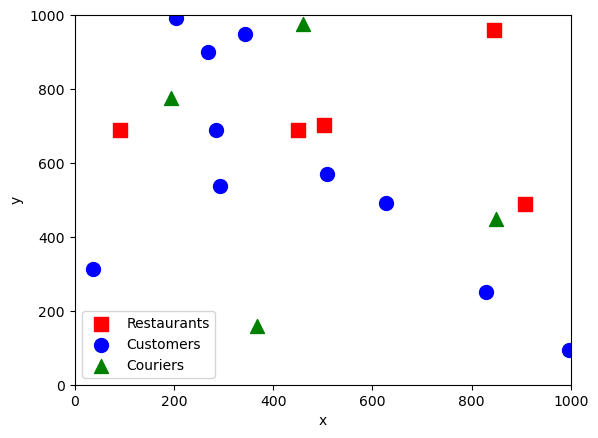

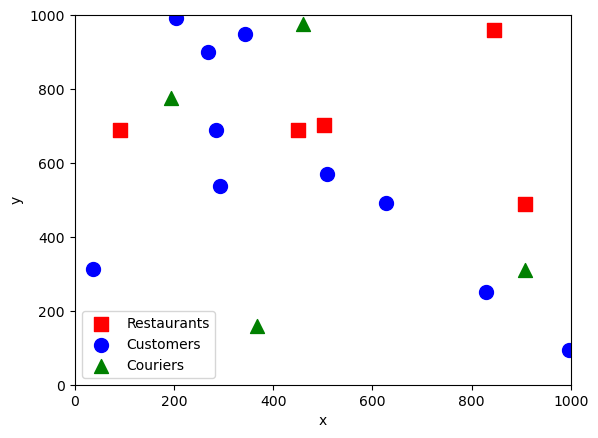

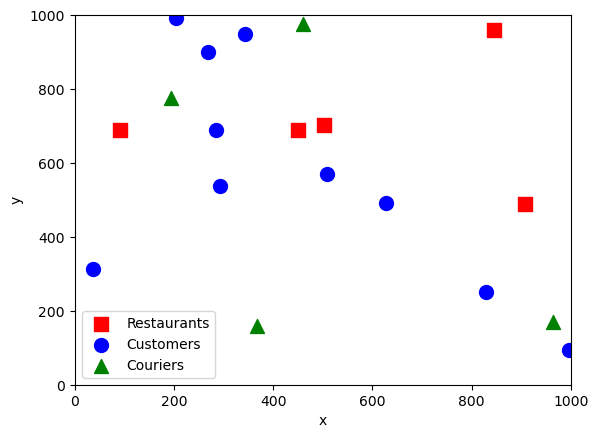

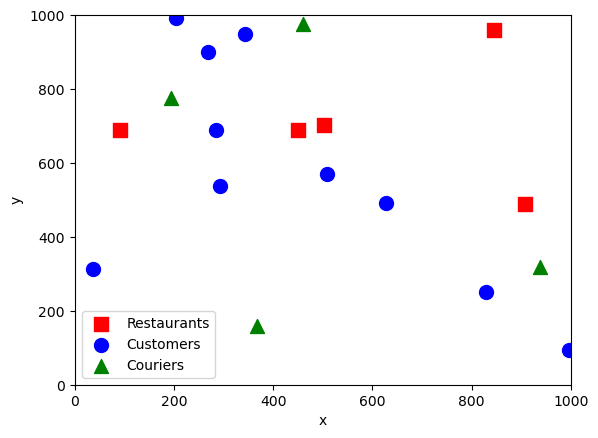

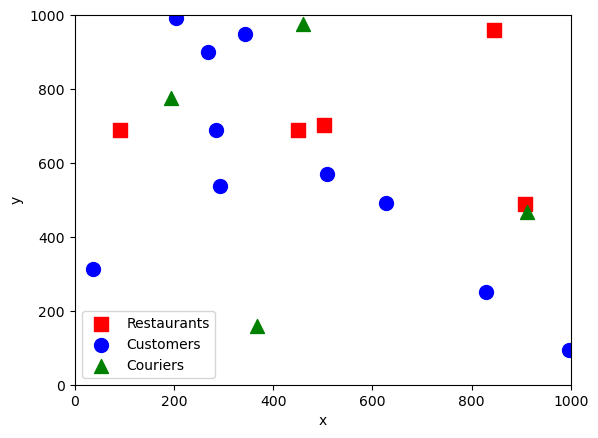

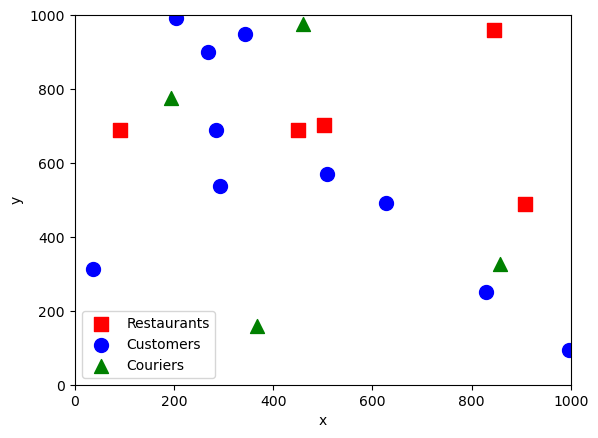

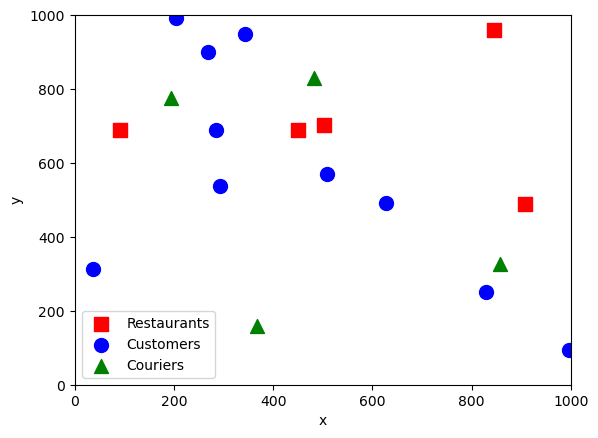

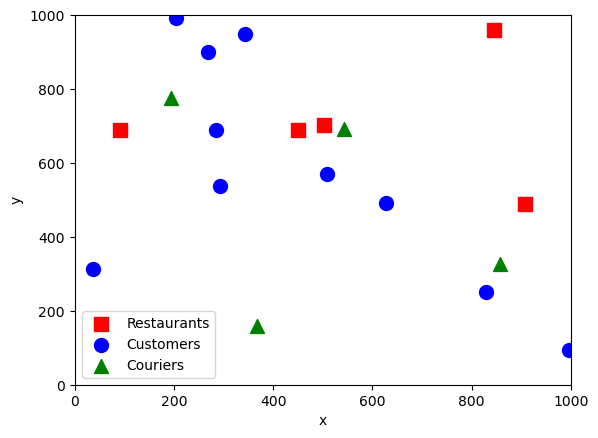

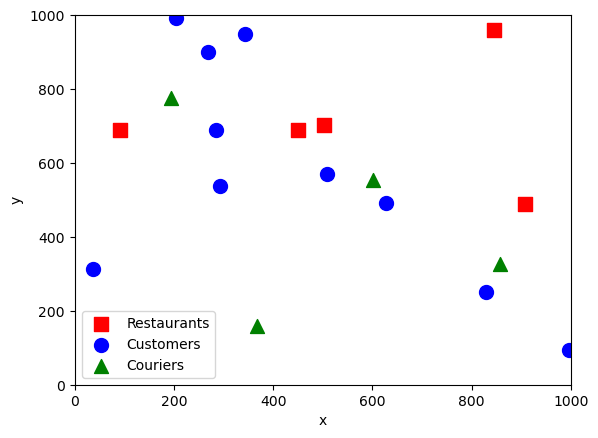

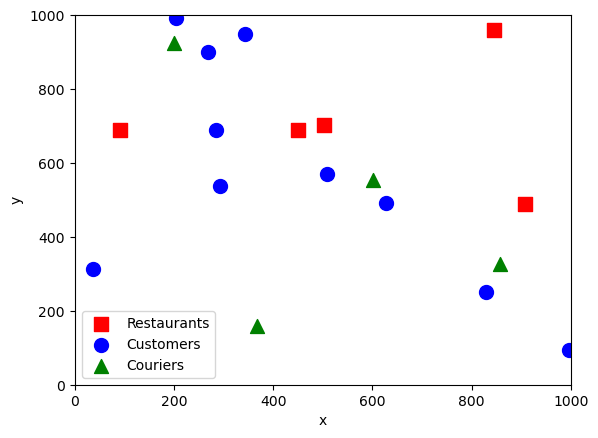

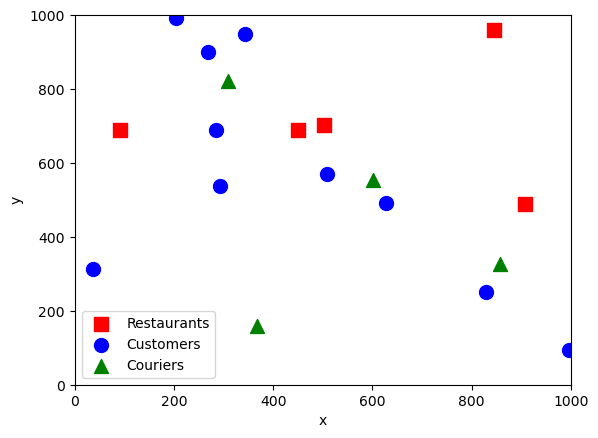

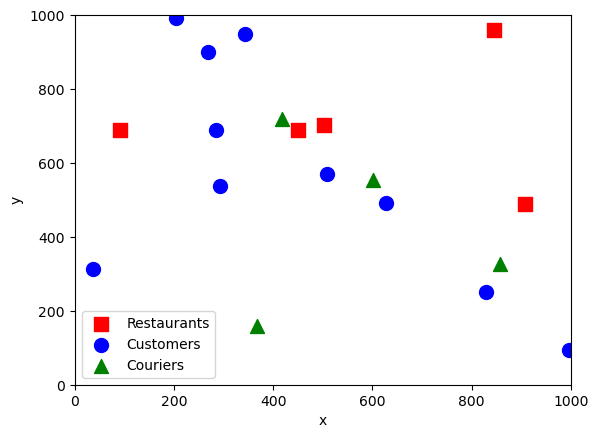

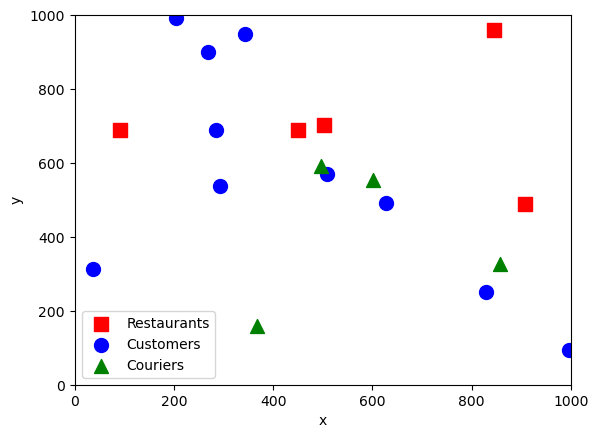

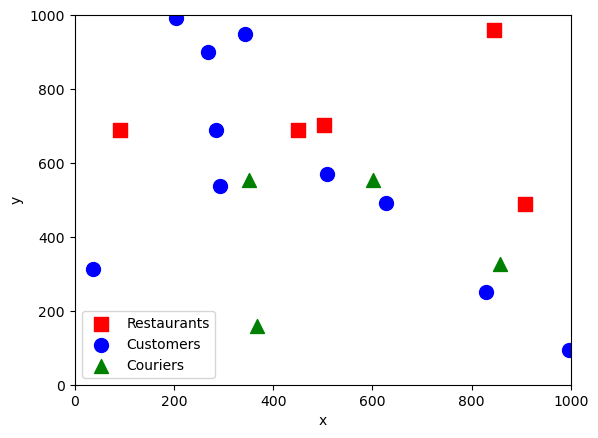

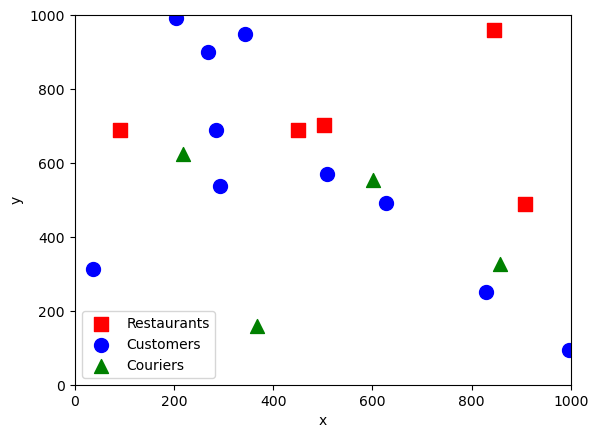

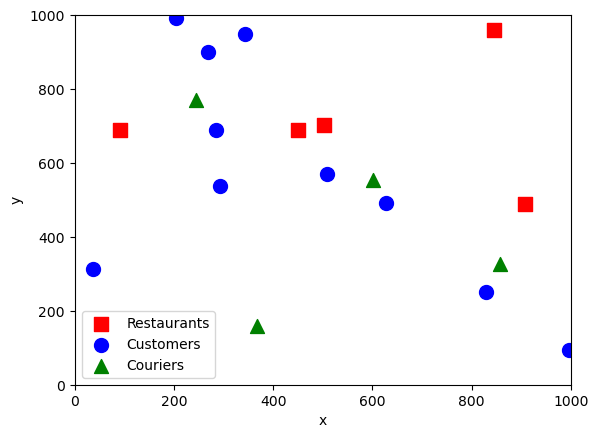

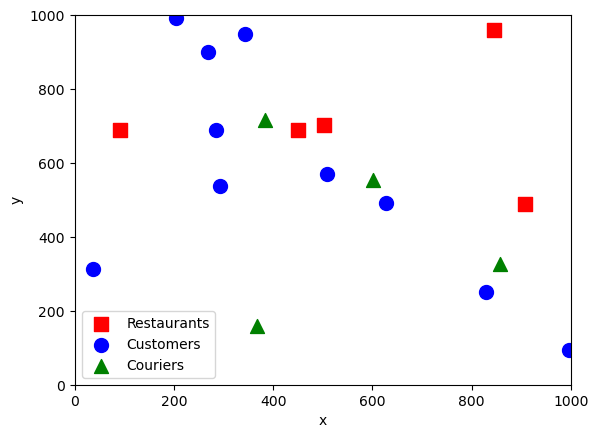

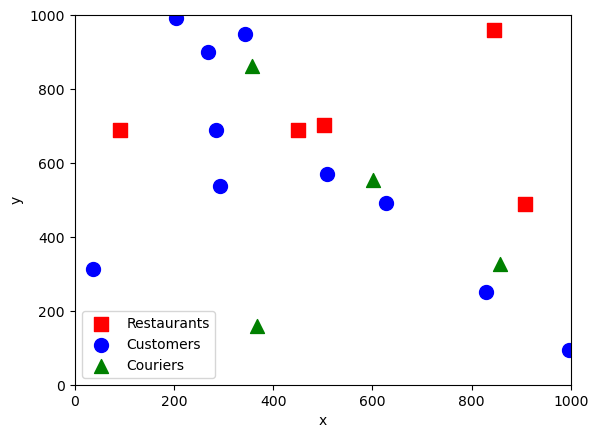

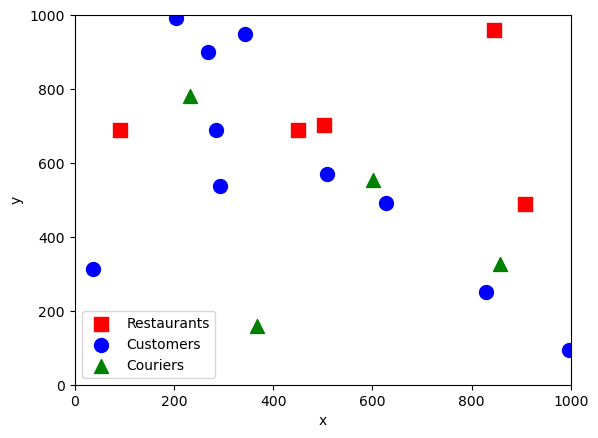

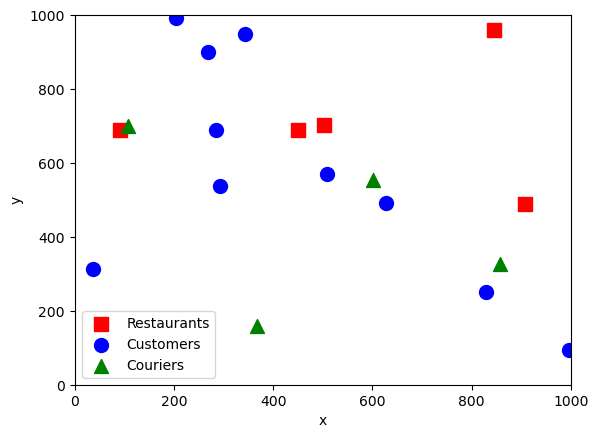

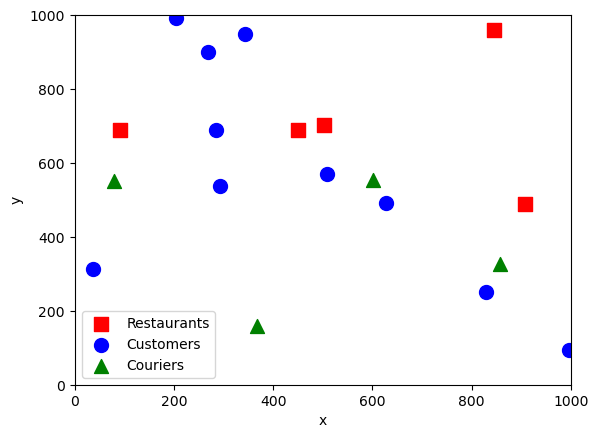

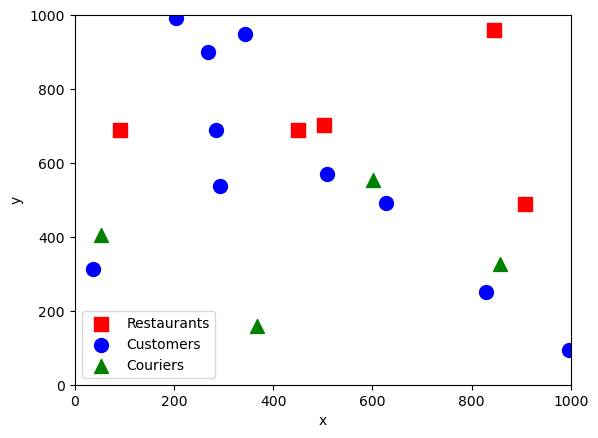

<Figure size 640x480 with 0 Axes>

In [2]:
def initialize_positions(n_customers, n_restaurants, n_couriers):
    customers = pd.DataFrame({'id': [f'c{i + 1}' for i in range(n_customers)],
                              'x': np.random.randint(0, 1000, n_customers),
                              'y': np.random.randint(0, 1000, n_customers)})
    restaurants = pd.DataFrame({'id': [f'r{i + 1}' for i in range(n_restaurants)],
                                'x': np.random.randint(0, 1000, n_restaurants),
                                'y': np.random.randint(0, 1000, n_restaurants)})
    couriers = pd.DataFrame({'id': [f'd{i + 1}' for i in range(n_couriers)],
                             'x': np.random.randint(0, 1000, n_couriers),
                             'y': np.random.randint(0, 1000, n_couriers),
                             'active': [True] * n_couriers})
    return customers, restaurants, couriers

def compute_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def assign_orders(customers, couriers, restaurants):
    assignments = []
    for _, customer in customers.iterrows():
        min_dist = float('inf')
        chosen_restaurant = None
        for _, restaurant in restaurants.iterrows():
            dist = compute_distance(customer['x'], customer['y'], restaurant['x'], restaurant['y'])
            if dist < min_dist:
                min_dist = dist
                chosen_restaurant = restaurant['id']
        assignments.append({'customer': customer['id'], 'restaurant': chosen_restaurant})
    
    courier_assignments = {courier['id']: [] for _, courier in couriers.iterrows()}
    for assignment in assignments:
        min_dist = float('inf')
        chosen_courier = None
        restaurant_coords = restaurants[restaurants['id'] == assignment['restaurant']].iloc[0]
        for _, courier in couriers.iterrows():
            dist = compute_distance(restaurant_coords['x'], restaurant_coords['y'], courier['x'], courier['y'])
            if dist < min_dist:
                min_dist = dist
                chosen_courier = courier['id']
        courier_assignments[chosen_courier].append(assignment)
    
    return courier_assignments

def simulate_courier_movements(couriers, courier_assignments, restaurants, customers, speed, inactivity_prob):
    def move_courier(courier, target_x, target_y, speed):
        dist = compute_distance(courier['x'], courier['y'], target_x, target_y)
        if dist <= speed:
            courier['x'] = target_x
            courier['y'] = target_y
        else:
            angle = np.arctan2(target_y - courier['y'], target_x - courier['x'])
            dx = speed * np.cos(angle)
            dy = speed * np.sin(angle)
            courier['x'] += dx
            courier['y'] += dy
        return courier

    movements = []
    for courier_id, assignments in courier_assignments.items():
        courier = couriers[couriers['id'] == courier_id].iloc[0]
        
        for assignment in assignments:
            restaurant = restaurants[restaurants['id'] == assignment['restaurant']].iloc[0]
            customer = customers[customers['id'] == assignment['customer']].iloc[0]
            
            # Move courier to restaurant
            while compute_distance(courier['x'], courier['y'], restaurant['x'], restaurant['y']) > speed:
                courier = move_courier(courier, restaurant['x'], restaurant['y'], speed)
                movements.append(courier.copy())

            # Move courier to customer
            while compute_distance(courier['x'], courier['y'], customer['x'], customer['y']) > speed:
                courier = move_courier(courier, customer['x'], customer['y'], speed)
                movements.append(courier.copy())

            # Check courier inactivity probability
            if random.random() < inactivity_prob:
                courier['active'] = False
                movements.append(courier.copy())
                break

    return pd.DataFrame(movements)


def plot_positions(couriers, customers, restaurants):
    plt.scatter(restaurants['x'], restaurants['y'], color='red', label='Restaurants', marker='s', s=100)
    plt.scatter(customers['x'], customers['y'], color='blue', label='Customers', marker='o', s=100)
    if not couriers.empty:
        plt.scatter(couriers['x'], couriers['y'], color='green', label='Couriers', marker='^', s=100)
    plt.xlim(0, 1000)
    plt.ylim(0, 1000)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.pause(0.5)
    plt.clf()

def main():
    n_customers = 10
    n_restaurants = 5
    n_couriers = 4
    speed = 150
    inactivity_prob = 0.2

    customers, restaurants, couriers = initialize_positions(n_customers, n_restaurants, n_couriers)
    courier_assignments = assign_orders(customers, couriers, restaurants)
    courier_movements = simulate_courier_movements(couriers, courier_assignments, restaurants, customers, speed, inactivity_prob)

    for _, movement in courier_movements.iterrows():
        couriers.loc[couriers['id'] == movement['id'], 'x'] = movement['x']
        couriers.loc[couriers['id'] == movement['id'], 'y'] = movement['y']
        couriers.loc[couriers['id'] == movement['id'], 'active'] = movement['active']
        active_couriers = couriers[couriers['active']]
        plot_positions(active_couriers, customers, restaurants)

    plt.show()

if __name__ == "__main__":
    main()
